<a href="https://colab.research.google.com/github/etgins/Computer-Vision-Alg-App-HW/blob/main/ML_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - Decision Trees

## Before you begin

Remember to:

1. Make your own copy of the notebook by pressing the "Copy to drive" button.
2. Expend all cells by pressing **Ctrl+[**

### Your IDs

✍️ Fill in your IDs in the cell below:

In [ ]:
## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
## Fill in your IDs (as a string)
student1_id = '312344245'
student2_id = '205540164'
## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%

print('Hello ' + student1_id + ' & ' + student2_id)

Hello 312344245 & 205540164


### Importing Packages

In [ ]:
import numpy as np  # Numerical package (mainly multi-dimensional arrays and linear algebra)
import pandas as pd  # A package for working with data frames
import matplotlib.pyplot as plt  # A plotting package

## Setup matplotlib to output figures into the notebook
%matplotlib inline

## Set some default values of the the matplotlib plots
plt.rcParams['figure.figsize'] = (6.0, 6.0)  # Set default plot's sizes
plt.rcParams['figure.dpi'] = 120  # Set default plot's dpi (increase fonts' size)
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## Seoul Bike Sharing Demand Dataset

Similar to the previous assignment, we will again work with the bike sharing dataset trying to predict the number of rented bikes in each hour according to the day of the week, the time of day and the weather.

### Loading the dataset

In [ ]:
dataset_location = 'https://technion046195.netlify.app/datasets/bike_demand.csv'

## Loading the data
dataset = pd.read_csv(dataset_location)

We shall plot the dataset again

In [ ]:
dataset

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Day of the week
0,01/12/2017,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,4
1,01/12/2017,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,4
2,01/12/2017,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,4
3,01/12/2017,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,4
4,01/12/2017,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
8052,30/11/2018,1003,19,4.2,34,2.6,1894,0.0,0.0,0.0,4
8053,30/11/2018,764,20,3.4,37,2.3,2000,0.0,0.0,0.0,4
8054,30/11/2018,694,21,2.6,39,0.3,1968,0.0,0.0,0.0,4
8055,30/11/2018,712,22,2.1,41,1.0,1859,0.0,0.0,0.0,4


✍️ Again we shall store all the relevant fields in a list named "x_fields". Fill in the name of the relevant fields we would like to use for our prediction (reminder: we do not want to use the "Date" field).

- You can basically copy this line from the last assignment.

In [ ]:
y_field = 'Rented Bike Count'

## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
## Fill in the name of the relevant fields.
x_fields = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)','Solar Radiation (MJ/m2)','Rainfall(mm)','Snowfall (cm)','Day of the week']
## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%

## Train-test split

We shall divide the dataset into 80% train and 20% train.

✍️ Copy the code from the last assignment in order to split the dataset

In [ ]:
n_samples = len(dataset)  # The total number of samples in the dataset

## Generate a random generator with a fixed seed
rand_gen = np.random.RandomState(0)

## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
## Generating a shuffled vector of indices
indices = np.arange(n_samples)
rand_gen.shuffle(indices)

## Split the indices into 80% train (full) / 20% test
n_samples_train_full = int(n_samples * 0.8)
train_full_indices = indices[:n_samples_train_full]
test_indices = indices[n_samples_train_full:]
## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%

## Extract the sub datasets from the full dataset using the calculated indices
train_full_set = dataset.iloc[train_full_indices]
test_set = dataset.iloc[test_indices]

## Train - validation split

We shall divide the train set into 75% train and 25% validation.

✍️ Complete the following code to create a train-validation split similar to the train-test split above:

In [ ]:
## Generate a random generator with a fixed (different) seed
rand_gen = np.random.RandomState(1)

## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
## Generating a shuffled vector of indices
indices = train_full_indices.copy()
rand_gen.shuffle(indices)

## Split the indices of the train (full) dataset into 75% train / 25% validation
n_samples_train =  int(n_samples_train_full * 0.75)
train_indices =  indices[:n_samples_train]
val_indices = indices[n_samples_train:]
## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%

## Extract the sub datasets from the full dataset using the calculated indices
train_set = dataset.iloc[train_indices]
val_set = dataset.iloc[val_indices]

## Extracting the features from the dataset

✍️ Complete the following code to create the $X$ martic and $\boldsymbol{y}$ vector for a given dataset. In this case we only want one column per each field in "x_fields" (no high orders). The is not need to add a bias term.

In [ ]:
def extract_x_y(dataset):
    ## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
    features = []
    for field in x_fields:
        features.append(dataset[field].values)
    
    x = np.stack(features, axis=1)
    y = dataset[y_field].values
    ## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%
    return x, y

x_train, y_train = extract_x_y(train_set)
x_val, y_val = extract_x_y(val_set)
x_train_full, y_train_full = extract_x_y(train_full_set)
x_test, y_test = extract_x_y(test_set)

## A Decision Tree for Regression

In call we have shown how a to use a decision tree to solve classification tasks. In this assignment we will show how they can also be used to solve regression problems. Specifically we will show how to do so for the case of an MSE / RMSE loss function.

In order to make our algorithm for building the trees useful for regression problems, we will make 2 adjustments:

1. The criteria which we will be using to selecting the best node to add will be the MSE (or the RMSE), replacing the Gini / entropy criteria.
2. The final prediction in the leafs of the tree will be selected as the mean of the labels of the samples reaching each leaf, when applying the decision tree to the train set. 

## A Stump - A decision tree of depth 1

We will start with a simple case of a tree of depth 1, i.e. a tree with a single split. Such decision trees are usually referred to as **stumps**. Since we are limiting our selves to splits of the form of $x_i\geq\alpha$, the stump has 4 parameters:

- $i$: the index of the component of $\boldsymbol{x}$ which we would like to compare.
- $\alpha$: the threshold.
- The predictions for each of the two leafs.

The following class implements a stump.

- The values of $i$ and $\alpha$ are fixed when the stump is created.
- The prediction values in the leafs are updated when calling the "fit" method with a set of $X$ and $\boldsymbol{y}$.
- The split function is an auxiliary function which creates two sets of indices which can be used to  split the data according the the stump condition.
- The predict method receives $X$ and produces a prediction $\hat{\boldsymbol{y}}$.

✍️ Go over the code and complete the code in the fit method such that the stab will learn the optimal prediction in each leaf based on the given data (x and y).

- Remember the optimal prediction in each node will be the mean value of the labels of the samples reaching each leaf.
- The fit function has two "if" functions to check if the split didn't produce an empty split (using the "any" function). The values of the predictions should be updated only if the split is not empty, other wise the predictions should be left with their initial values (-1).

In [ ]:
class Stump:
    def __init__(self, field_num, threshold):
        ## Initizalizing the stump with some fixed values of field_num (i) and threshold (alpha)
        self.field_num = field_num
        self.threshold = threshold
        
        self.true_leaf_prediciton = -1  ## This is a place holder until the fit function is called
        self.false_leaf_prediction = -1  ## This is a place holder until the fit function is called
    
    def split(self, x):
        ## An auxiliary function for generating indices for splitting the data.
        true_indices = (x[:, self.field_num] >= self.threshold)
        false_indices = (x[:, self.field_num] < self.threshold)
        return true_indices, false_indices

    def fit(self, x, y):
        true_indices, false_indices = self.split(x)
        ## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
        if true_indices.any():
            self.true_leaf_prediciton = np.mean(y[true_indices])
        if false_indices.any():
            self.false_leaf_prediction = np.mean(y[false_indices])
        ## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%

    def predict(self, x):
        y_hat = np.zeros(x.shape[0])
        true_indices, false_indices = self.split(x)
        y_hat[true_indices] = self.true_leaf_prediciton
        y_hat[false_indices] = self.false_leaf_prediction
        return y_hat

## Test
stump = Stump(0, 10)
stump.fit(x_train, y_train)
print(f'true_leaf_prediciton: {stump.true_leaf_prediciton}')
print(f'false_leaf_prediction: {stump.false_leaf_prediction}')

true_leaf_prediciton: 946.0944937833037
false_leaf_prediction: 461.5713577799802


Make sure that you get results around 950 and 450 in the above cell.

This function below is uses a package name "graphviz" to plot stumps. You do not need to go over it.

In [ ]:
from graphviz import Digraph  # A package for plothing graphs (of nodes and edges)
def plot_stump(stump):
    node_style = {'style': 'filled', 'fillcolor': '#DAE8FC', 'color': '#6C8EBF', 'penwidth': '3'}
    edge_style = {'penwidth': '2'}

    node_text = f'{x_fields[stump.field_num]} >= {int(stump.threshold)}'
    
    tree_graph = Digraph()
    tree_graph.node('root', '<<I><B>x</B></I>>', shape='plaintext')
    tree_graph.edge('root', 'node', **edge_style)
    tree_graph.node('node', node_text, **node_style)
    tree_graph.edge('node', 'node_0', 'No', **edge_style)
    tree_graph.node('node_0', f'{int(stump.false_leaf_prediction)}', shape='plaintext')
    tree_graph.edge('node', 'node_1', 'Yes', **edge_style)
    tree_graph.node('node_1', f'{int(stump.true_leaf_prediciton)}', shape='plaintext')
    return tree_graph

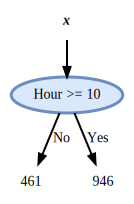

In [ ]:
plot_stump(stump)

Let's look at some predictions

In [ ]:
print(f'x1 values (hour): {x_train[:10, 0]}')
print(f'Predictions     : {stump.predict(x_train).astype(int)[:10]}')

x1 values (hour): [21.  8.  8.  9. 10.  9.  1.  6. 17.  9.]
Predictions     : [946 461 461 461 946 461 461 461 946 461]


## Calculating the RMSE

Since we will use a RMSE both of selecting the node to add at each step and to evaluated the out model, let's implement a function which calculated the RMSE for a given model and a dataset ($X$ and $\boldsymbol{y}$).

✍️ Complete the code below so that it will compute the RMSE of the model in the given dataset.

In [ ]:
def calc_model_rmse(model, x, y):
    y_hat = model.predict(x)
    ## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
    rmse = np.sqrt(np.mean((y_hat-y)**2))
   
    ## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%
    return rmse

calc_model_rmse(stump, x_train, y_train)

603.2358102828449

## Searching for the best stump

Since the greedy algorithm for growing the trees looks for the best stump in each step, we need to implement a function which find that stump for a given dataset. We will do so by going over all the possible stumps.

✍️ Complete the code which searches for the best stump:

556.3287243600591


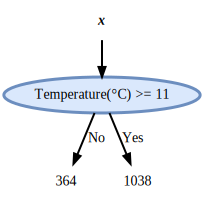

In [ ]:
def find_best_stump(x, y):
    best_stump = None
    best_score = np.inf
    for field_num in range(x.shape[1]):  # Go over all fields
        for val in x[:, field_num]:  # Go over all relevant threshold
            ## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
            stump = Stump(field_num, val)   # Build a stump with the given field and threshold
            stump.fit(x, y)  ## Do some additional processing
            score = calc_model_rmse(stump, x, y) ## Calculate the RMSE score for the stump
            if score < best_score: ## If it is better that the best stump so far store it as the best
                best_stump = stump
                best_score = score
            ## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%
    return best_stump, best_score

best_stump, best_score = find_best_stump(x_train, y_train)
print(best_score)
plot_stump(best_stump)

Make sure you get a split according to the temperature.

## Deeper Trees

Below is a implementation of a node in a general tree with an arbitrary depth. Each node object can be either a leaf or a split (like a stump). For the case where the node is a split it points to the two next nodes in the tree.

Each node is initialized as a leaf with a fixed prediction and can later become a split in the growing process. when the growing function is called on a node which is a leaf is uses the "find_best_stump" function to search for the optimal split which will replace the leaf. When the growing function is called on a node which is a split, it splits the data and calls the growing function on the child nodes.

This class is already fully implemented including the growing function and the pruning function and it is build upon the function which we had defined so far. You are encouraged to go over it and try make sure you understand how the growing process works and the pruning work.

In [ ]:
class Node:
    def __init__(self, prediction):
        self.is_leaf = True
        
        self.prediction = prediction

        self.field_num = None
        self.threshold = None
        self.node_true = None
        self.node_false = None
    
    def split(self, x):
        true_indices = (x[:, self.field_num] >= self.threshold)
        false_indices = (x[:, self.field_num] < self.threshold)
        return true_indices, false_indices

    def predict(self, x):
        y_hat = np.zeros(x.shape[0])
        if self.is_leaf:
            y_hat[:] = self.prediction
        else:
            true_indices, false_indices = self.split(x)
            y_hat[true_indices] = self.node_true.predict(x[true_indices])
            y_hat[false_indices] = self.node_false.predict(x[false_indices])
        return y_hat
    
    def grow_one_level(self, x, y):
        if not self.is_leaf:
            true_indices, false_indices = self.split(x)
            self.node_true.grow_one_level(x[true_indices], y[true_indices])
            self.node_false.grow_one_level(x[false_indices], y[false_indices])
        else:
            score_before = calc_model_rmse(self, x, y)
            best_stump, best_score = find_best_stump(x, y)
            if best_score < score_before:
                self.is_leaf = False
                self.field_num = best_stump.field_num
                self.threshold = best_stump.threshold
                self.node_true = Node(best_stump.true_leaf_prediciton)
                self.node_false = Node(best_stump.false_leaf_prediction)
    
    def prune(self, x, y):
        if not self.is_leaf:
            true_indices, false_indices = self.split(x)
            if not (true_indices.any() and false_indices.any()):
                self.is_leaf = True
            else:
                self.node_true.prune(x[true_indices], y[true_indices])
                self.node_false.prune(x[false_indices], y[false_indices])
                if self.node_true.is_leaf and self.node_false.is_leaf:
                    score_with = calc_model_rmse(self, x, y)
                    self.is_leaf = True
                    score_without = calc_model_rmse(self, x, y)
                    if score_with < score_without:
                        self.is_leaf = False

And a function to plot the tree:

In [ ]:
def plot_tree(tree):
    node_style = {'style': 'filled', 'fillcolor': '#DAE8FC', 'color': '#6C8EBF', 'penwidth': '3'}
    edge_style = {'penwidth': '2'}

    def add_node_to_tree(node, index):
        if node.is_leaf:
            tree_graph.node(index, f'{int(node.prediction)}', shape='plaintext')
        else:
            node_text = f'{x_fields[node.field_num]} >= {int(node.threshold)}'
            tree_graph.node(index, node_text, **node_style)
            tree_graph.edge(index, index + '_0', 'No', **edge_style)
            add_node_to_tree(node.node_false, index + '_0')
            tree_graph.edge(index, index + '_1', 'Yes', **edge_style)
            add_node_to_tree(node.node_true, index + '_1')
        
    tree_graph = Digraph(comment='Tree')
    tree_graph.format = 'png'
    tree_graph.node('root', '<<I><B>x</B></I>>', shape='plaintext')
    tree_graph.edge('root', 'node', **edge_style)
    add_node_to_tree(tree, 'node')
    
    return tree_graph

## Growing a tree

### Depth = 0

We will start with a tree of 0 depth (only a single leaf). We will initialized it with the optimal constant predictor which is the mean value of the labels over all the train set.

The RMSE score in the train is: 648.84
The RMSE score in the validation is: 642.39


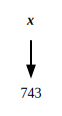

In [ ]:
tree = Node(y_train.mean())
print(f'The RMSE score in the train is: {calc_model_rmse(tree, x_train, y_train):.2f}')
print(f'The RMSE score in the validation is: {calc_model_rmse(tree, x_val, y_val):.2f}')
plot_tree(tree)

### Depth = 1

We will now call the "grow_one_level" function to add an extra layer to the tree:

The RMSE score in the train is: 556.33
The RMSE score in the validation is: 541.58


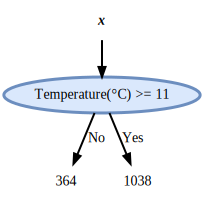

In [ ]:
tree.grow_one_level(x_train, y_train)
print(f'The RMSE score in the train is: {calc_model_rmse(tree, x_train, y_train):.2f}')
print(f'The RMSE score in the validation is: {calc_model_rmse(tree, x_val, y_val):.2f}')
plot_tree(tree)

## Depth = 2

The RMSE score in the train is: 470.44
The RMSE score in the validation is: 450.50


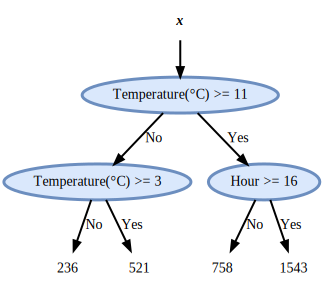

In [ ]:
tree.grow_one_level(x_train, y_train)
print(f'The RMSE score in the train is: {calc_model_rmse(tree, x_train, y_train):.2f}')
print(f'The RMSE score in the validation is: {calc_model_rmse(tree, x_val, y_val):.2f}')
plot_tree(tree)

### Depth = 3

The RMSE score in the train is: 393.23
The RMSE score in the validation is: 386.88


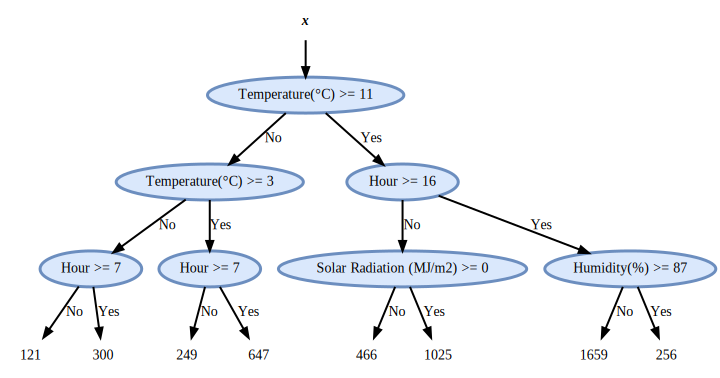

In [ ]:
tree.grow_one_level(x_train, y_train)
print(f'The RMSE score in the train is: {calc_model_rmse(tree, x_train, y_train):.2f}')
print(f'The RMSE score in the validation is: {calc_model_rmse(tree, x_val, y_val):.2f}')
plot_tree(tree)

## Growing until depth = 13

We shall stop plotting the tree from here.

In [ ]:
for level in range(4, 14):
    print(f'\nLevel {level}:')
    tree.grow_one_level(x_train, y_train)
    print(f'The RMSE score in the train is: {calc_model_rmse(tree, x_train, y_train):.2f}')
    print(f'The RMSE score in the validation is: {calc_model_rmse(tree, x_val, y_val):.2f}')


Level 4:
The RMSE score in the train is: 364.48
The RMSE score in the validation is: 361.72

Level 5:
The RMSE score in the train is: 331.24
The RMSE score in the validation is: 328.86

Level 6:
The RMSE score in the train is: 296.80
The RMSE score in the validation is: 296.11

Level 7:
The RMSE score in the train is: 268.52
The RMSE score in the validation is: 280.47

Level 8:
The RMSE score in the train is: 241.99
The RMSE score in the validation is: 274.06

Level 9:
The RMSE score in the train is: 211.13
The RMSE score in the validation is: 262.83

Level 10:
The RMSE score in the train is: 183.85
The RMSE score in the validation is: 255.81

Level 11:
The RMSE score in the train is: 155.16
The RMSE score in the validation is: 257.03

Level 12:
The RMSE score in the train is: 128.76
The RMSE score in the validation is: 255.72

Level 13:
The RMSE score in the train is: 105.86
The RMSE score in the validation is: 258.44


### Pruning

We can now use the pruning function to prune the tree using the validation set.

In [ ]:
tree.prune(x_val, y_val)
print(f'The RMSE score in the train is: {calc_model_rmse(tree, x_train, y_train):.2f}')
print(f'The RMSE score in the validation is: {calc_model_rmse(tree, x_val, y_val):.2f}')

The RMSE score in the train is: 187.02
The RMSE score in the validation is: 231.42


## Final evaluation

Evaluate the model using the test set

✍️ Complete the code below the evaluate the RMSE on the test set

In [ ]:
## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
print(f'The RMSE score in the test is: {calc_model_rmse(tree, x_test, y_test):.2f}')
## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%

The RMSE score in the test is: 247.94


## Decision trees in scikit-learn

The scikit-learn package also has an implementation for decision trees. Use the documentation of the [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) object and use in to grow a tree of depth 13. Evaluate the train and validation errors on the new trained, and check that you get the same results as with implementation in this notebook.

- Note that the run time of the scikit-learn implementation is significantly faster, mainly due to a more efficient implementation of the search for the best split.

✍️ Complete the code below to train and evaluate a decision tree of depth 13 using the scikit-learn package:

In [ ]:
from sklearn.tree import DecisionTreeRegressor

## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
tree2 = DecisionTreeRegressor(max_depth=13)
tree2.fit(x_train, y_train);
# %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%

print(f'The RMSE score in the train is: {calc_model_rmse(tree2, x_train, y_train):.2f}')
print(f'The RMSE score in the validation is: {calc_model_rmse(tree2, x_val, y_val):.2f}')

The RMSE score in the train is: 105.86
The RMSE score in the validation is: 260.13


## Submission

To submit your code download it as a **ipynb** file from Colab, and upload it to the course's website (Moodle). You can download this code by selecting **Download .ipynb** from the **file** menu.